# Libraries

In [1]:
# import libraries
# ================

# for date and time opeations
from datetime import datetime, timedelta
# for file and folder operations
import os
# for regular expression opeations
import re
# for listing files in a folder
import glob
# for getting web contents
import requests 
# storing and analysing data
import pandas as pd
# for scraping web contents
from bs4 import BeautifulSoup
# to download data
import wget
# numerical analysis
import numpy as np

# Downloading data

In [2]:
# remove all existing csv files
! rm *.csv

# urls of the files
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

# download files
for url in urls:
    filename = wget.download(url)

100% [............................................................................] 116190 / 116190

# Dataframes

In [3]:
# dataset
# ======

conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [4]:
# conf_df.head()
# deaths_df.head()
# recv_df.head()

In [5]:
# conf_df.columns
# deaths_df.columns
# recv_df.columns

In [6]:
# conf_df.columns[4:]
# deaths_df.columns[4:]
# recv_df.columns[4:]

# Merging dataframes

In [7]:
# extract dates
dates = conf_df.columns[4:]

# melt dataframes in longer format
conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')

recv_df_long = recv_df_long[recv_df_long['Country/Region']!='Canada']

print(conf_df_long.shape)
print(deaths_df_long.shape)
print(recv_df_long.shape)

(37506, 6)
(37506, 6)
(35532, 6)


In [8]:
# merge dataframes

# full_table = pd.concat([conf_df_long, deaths_df_long['Deaths'], recv_df_long['Recovered']], 
#                        axis=1, sort=False)

full_table = pd.merge(left=conf_df_long, right=deaths_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])
full_table = pd.merge(left=full_table, right=recv_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0.0,0.0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0.0,0.0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0.0,0.0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0.0,0.0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0.0,0.0


In [9]:
# Convert to proper date format
full_table['Date'] = pd.to_datetime(full_table['Date'])

In [10]:
# full_table.shape

In [11]:
# full_table.isna().sum()

In [12]:
# full_table[full_table['Recovered'].isna()]['Country/Region'].value_counts()

In [13]:
# full_table[full_table['Recovered'].isna()]['Date'].value_counts()

In [14]:
full_table['Recovered'] = full_table['Recovered'].fillna(0)
full_table['Recovered'] = full_table['Recovered'].astype('int')
# full_table.isna().sum()

# Preprocessing

In [15]:
# fixing Country names
# ====================

# renaming countries, regions, provinces
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', 'South Korea')

# Greenland
full_table.loc[full_table['Province/State']=='Greenland', 'Country/Region'] = 'Greenland'

# Mainland china to China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

In [16]:
# removing
# =======

# removing canada's recovered values
full_table = full_table[full_table['Province/State'].str.contains('Recovered')!=True]

# removing county wise data to avoid double counting
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]

In [17]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# filling missing values 
# ======================
# fill missing province/state value with ''
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# fill missing numerical values with 0
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
full_table[cols] = full_table[cols].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

# random rows
full_table.sample(6)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
27555,,Mauritius,-20.2000,57.5000,2020-05-04,332,10.0,316,6.0
7829,Martinique,France,14.6415,-61.0242,2020-02-20,0,0.0,0,0.0
2485,,Czechia,49.8175,15.4730,2020-01-31,0,0.0,0,0.0
32632,,Paraguay,-23.4425,-58.4438,2020-05-23,850,11.0,298,541.0
28846,,Gambia,13.4432,-15.3101,2020-05-09,20,1.0,9,10.0
1324,,Western Sahara,24.2155,-12.8858,2020-01-26,0,0.0,0,0.0


# Fixing off data

In [18]:
# new values
feb_12_conf = {'Hubei' : 34874}

In [19]:
# function to change value
def change_val(date, ref_col, val_col, dtnry):
    for key, val in dtnry.items():
        full_table.loc[(full_table['Date']==date) & (full_table[ref_col]==key), val_col] = val

In [20]:
# changing values
change_val('2/12/20', 'Province/State', 'Confirmed', feb_12_conf)

In [21]:
# checking values
full_table[(full_table['Date']=='2/12/20') & (full_table['Province/State']=='Hubei')]

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
5648,Hubei,China,30.9756,112.2707,2020-02-12,34874,1068.0,2686,29612.0


In [22]:
# Ship
# ====

# ship rows containing ships with COVID-19 reported cases
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | \
            full_table['Province/State'].str.contains('Diamond Princess') | \
            full_table['Country/Region'].str.contains('Diamond Princess') | \
            full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# Latest cases from the ships
ship_latest = ship[ship['Date']==max(ship['Date'])]
# ship_latest.style.background_gradient(cmap='Pastel1_r')

# skipping rows with ships info
full_table = full_table[~(ship_rows)]

# WHO Region

In [23]:
# link

In [24]:
# img

In [25]:
who_region = {}

# African Region AFRO
afro = "Algeria, Angola, Cabo Verde, Eswatini, Sao Tome and Principe, Benin, South Sudan, Western Sahara, Congo (Brazzaville), Congo (Kinshasa), Cote d'Ivoire, Botswana, Burkina Faso, Burundi, Cameroon, Cape Verde, Central African Republic, Chad, Comoros, Ivory Coast, Democratic Republic of the Congo, Equatorial Guinea, Eritrea, Ethiopia, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Kenya, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mauritius, Mozambique, Namibia, Niger, Nigeria, Republic of the Congo, Rwanda, São Tomé and Príncipe, Senegal, Seychelles, Sierra Leone, Somalia, South Africa, Swaziland, Togo, Uganda, Tanzania, Zambia, Zimbabwe"
afro = [i.strip() for i in afro.split(',')]
for i in afro:
    who_region[i] = 'Africa'
    
# Region of the Americas PAHO
paho = 'Antigua and Barbuda, Argentina, Bahamas, Barbados, Belize, Bolivia, Brazil, Canada, Chile, Colombia, Costa Rica, Cuba, Dominica, Dominican Republic, Ecuador, El Salvador, Grenada, Guatemala, Guyana, Haiti, Honduras, Jamaica, Mexico, Nicaragua, Panama, Paraguay, Peru, Saint Kitts and Nevis, Saint Lucia, Saint Vincent and the Grenadines, Suriname, Trinidad and Tobago, United States, US, Uruguay, Venezuela'
paho = [i.strip() for i in paho.split(',')]
for i in paho:
    who_region[i] = 'Americas'

# South-East Asia Region SEARO
searo = 'Bangladesh, Bhutan, North Korea, India, Indonesia, Maldives, Myanmar, Burma, Nepal, Sri Lanka, Thailand, Timor-Leste'
searo = [i.strip() for i in searo.split(',')]
for i in searo:
    who_region[i] = 'South-East Asia'

# European Region EURO
euro = 'Albania, Andorra, Greenland, Kosovo, Holy See, Liechtenstein, Armenia, Czechia, Austria, Azerbaijan, Belarus, Belgium, Bosnia and Herzegovina, Bulgaria, Croatia, Cyprus, Czech Republic, Denmark, Estonia, Finland, France, Georgia, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Kazakhstan, Kyrgyzstan, Latvia, Lithuania, Luxembourg, Malta, Monaco, Montenegro, Netherlands, North Macedonia, Norway, Poland, Portugal, Moldova, Romania, Russia, San Marino, Serbia, Slovakia, Slovenia, Spain, Sweden, Switzerland, Tajikistan, Turkey, Turkmenistan, Ukraine, United Kingdom, Uzbekistan'
euro = [i.strip() for i in euro.split(',')]
for i in euro:
    who_region[i] = 'Europe'

# Eastern Mediterranean Region EMRO
emro = 'Afghanistan, Bahrain, Djibouti, Egypt, Iran, Iraq, Jordan, Kuwait, Lebanon, Libya, Morocco, Oman, Pakistan, Palestine, West Bank and Gaza, Qatar, Saudi Arabia, Somalia, Sudan, Syria, Tunisia, United Arab Emirates, Yemen'
emro = [i.strip() for i in emro.split(',')]
for i in emro:
    who_region[i] = 'Eastern Mediterranean'

# Western Pacific Region WPRO
wpro = 'Australia, Brunei, Cambodia, China, Cook Islands, Fiji, Japan, Kiribati, Laos, Malaysia, Marshall Islands, Micronesia, Mongolia, Nauru, New Zealand, Niue, Palau, Papua New Guinea, Philippines, South Korea, Samoa, Singapore, Solomon Islands, Taiwan, Taiwan*, Tonga, Tuvalu, Vanuatu, Vietnam'
wpro = [i.strip() for i in wpro.split(',')]
for i in wpro:
    who_region[i] = 'Western Pacific'

In [26]:
full_table['WHO Region'] = full_table['Country/Region'].map(who_region)
full_table[full_table['WHO Region'].isna()]['Country/Region'].unique()

array([], dtype=object)

In [27]:
# Cleaning data
# =============

# fixing Country values
full_table.loc[full_table['Province/State']=='Greenland', 'Country/Region'] = 'Greenland'

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed', 'Deaths', 'Recovered', 'Active']] = full_table[['Confirmed', 'Deaths', 'Recovered', 'Active']].fillna(0)

# fixing datatypes
full_table['Recovered'] = full_table['Recovered'].astype(int)

full_table.sample(6)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
27234,,Estonia,58.5953,25.0136,2020-05-03,1700,55.0,259,1386.0,Europe
8306,Henan,China,33.8820,113.6140,2020-02-22,1270,0.0,0,1270.0,Western Pacific
32907,,Saint Lucia,13.9094,-60.9789,2020-05-24,18,0.0,18,0.0,Americas
11883,,Papua New Guinea,-6.3150,143.9555,2020-03-06,0,0.0,0,0.0,Western Pacific
33061,Tianjin,China,39.3054,117.3230,2020-05-25,192,3.0,188,1.0,Western Pacific
6153,Alberta,Canada,53.9333,-116.5765,2020-02-14,0,0.0,0,0.0,Americas


# Saving final data

In [28]:
full_table.to_csv('covid_19_clean_complete.csv', index=False)

# Full Grouped

In [29]:
# Grouped by day, country
# =======================

full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# new cases ======================================================
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# =================================================================

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])

# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

full_grouped.head()

C:\Users\imdevskp\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
C:\Users\imdevskp\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
0,2020-01-22,Afghanistan,0,0.0,0,0.0,0,0,0
1,2020-01-22,Albania,0,0.0,0,0.0,0,0,0
2,2020-01-22,Algeria,0,0.0,0,0.0,0,0,0
3,2020-01-22,Andorra,0,0.0,0,0.0,0,0,0
4,2020-01-22,Angola,0,0.0,0,0.0,0,0,0


In [30]:
full_grouped['WHO Region'] = full_grouped['Country/Region'].map(who_region)
full_grouped[full_grouped['WHO Region'].isna()]['Country/Region'].unique()

array([], dtype=object)

In [31]:
full_grouped.to_csv('full_grouped.csv', index=False)

# Day wise

In [32]:
# Day wise
# ========

# table
day_wise = full_grouped.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 
                                        'Active', 'New cases', 'New deaths', 'New recovered'].sum().reset_index()

# number cases per 100 cases
day_wise['Deaths / 100 Cases'] = round((day_wise['Deaths']/day_wise['Confirmed'])*100, 2)
day_wise['Recovered / 100 Cases'] = round((day_wise['Recovered']/day_wise['Confirmed'])*100, 2)
day_wise['Deaths / 100 Recovered'] = round((day_wise['Deaths']/day_wise['Recovered'])*100, 2)

# no. of countries
day_wise['No. of countries'] = full_grouped[full_grouped['Confirmed']!=0] \
                                    .groupby('Date')['Country/Region'] \
                                    .unique() \
                                    .apply(len)\
                                    .values

# fillna by 0
cols = ['Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']
day_wise[cols] = day_wise[cols].fillna(0)

day_wise.head()

C:\Users\imdevskp\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17.0,28,510.0,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18.0,30,606.0,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,25.0,35,881.0,287,7,5,2.66,3.72,71.43,9
3,2020-01-25,1434,41.0,38,1355.0,493,16,3,2.86,2.65,107.89,11
4,2020-01-26,2118,53.0,51,2014.0,684,12,13,2.50,2.41,103.92,13


In [33]:
day_wise.to_csv('day_wise.csv', index=False)

# Country wise latest

In [34]:
# Country wise
# ============

full_grouped['Date'] = pd.to_datetime(full_grouped['Date'])

# getting latest values
country_wise = full_grouped[full_grouped['Date']==max(full_grouped['Date'])] \
                    .reset_index(drop=True) \
                    .drop('Date', axis=1)

print(country_wise.shape)

# group by country
country_wise = country_wise.groupby('Country/Region')['Confirmed', 'Deaths', 
                                                      'Recovered', 'Active', 
                                                      'New cases', 'New deaths', 'New recovered'].sum().reset_index()
print(country_wise.shape)


# per 100 cases
country_wise['Deaths / 100 Cases'] = round((country_wise['Deaths']/country_wise['Confirmed'])*100, 2)
country_wise['Recovered / 100 Cases'] = round((country_wise['Recovered']/country_wise['Confirmed'])*100, 2)
country_wise['Deaths / 100 Recovered'] = round((country_wise['Deaths']/country_wise['Recovered'])*100, 2)

cols = ['Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']
country_wise[cols] = country_wise[cols].fillna(0)


# 1 week increase and % change
# ============================

today = full_grouped[full_grouped['Date']==max(full_grouped['Date'])] \
            .reset_index(drop=True) \
            .drop('Date', axis=1)[['Country/Region', 'Confirmed']]

last_week = full_grouped[full_grouped['Date']==max(full_grouped['Date'])-timedelta(days=7)] \
                .reset_index(drop=True) \
                .drop('Date', axis=1)[['Country/Region', 'Confirmed']]

temp = pd.merge(today, last_week, on='Country/Region', suffixes=(' today', ' last week'))
temp['1 week change'] = temp['Confirmed today'] - temp['Confirmed last week']
temp = temp[['Country/Region', 'Confirmed last week', '1 week change']]

country_wise = pd.merge(country_wise, temp, on='Country/Region')
country_wise['1 week % increase'] = round(country_wise['1 week change']/country_wise['Confirmed last week']*100, 2)
country_wise.head()

country_wise['WHO Region'] = country_wise['Country/Region'].map(who_region)
country_wise[country_wise['WHO Region'].isna()]['Country/Region'].unique()

country_wise.head()

(187, 9)
(187, 8)


C:\Users\imdevskp\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,22142,405.0,3013,18724.0,683,21,362,1.83,13.61,13.44,17267,4875,28.23,Eastern Mediterranean
1,Albania,1341,34.0,980,327.0,42,0,20,2.54,73.08,3.47,1184,157,13.26,Europe
2,Algeria,10484,732.0,7074,2678.0,102,8,123,6.98,67.47,10.35,9733,751,7.72,Africa
3,Andorra,852,51.0,759,42.0,0,0,2,5.99,89.08,6.72,851,1,0.12,Europe
4,Angola,113,4.0,40,69.0,17,0,2,3.54,35.40,10.00,86,27,31.40,Africa


In [35]:
country_wise.to_csv('country_wise_latest.csv', index=False)

# Country wise data

In [36]:
# # china
# # =====

# china_province_wise = full_table[full_table['Country/Region']=='China']
# china_province_wise['Province/State'].unique()
# china_province_wise.to_csv('china_province_wise.csv', index=False)

In [37]:
# # Australia
# # =========

# australia_state_wise = full_table[full_table['Country/Region']=='Australia']
# australia_state_wise['Province/State'].unique()
# australia_state_wise.to_csv('australia_state_wise.csv', index=False)

In [38]:
# # Canada
# # ======

# canada_state_wise = full_table[full_table['Country/Region']=='Canada']
# canada_state_wise['Province/State'].unique()
# canada_state_wise.to_csv('canada_state_wise.csv', index=False)

# USA data

In [39]:
# urls of the files
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv']

# download files
for url in urls:
    filename = wget.download(url)

100% [..........................................................................] 1297323 / 1297323

In [40]:
us_conf_df = pd.read_csv('time_series_covid19_confirmed_US.csv')
us_deaths_df = pd.read_csv('time_series_covid19_deaths_US.csv')

In [41]:
# us_conf_df.head()
# us_deaths_df.head()

In [42]:
# us_conf_df.columns
# us_deaths_df.columns

In [43]:
ids = us_conf_df.columns[0:11]
us_dates = us_conf_df.columns[11:]

us_conf_df_long = us_conf_df.melt(id_vars=ids, value_vars=us_dates, var_name='Date', value_name='Confirmed')
us_deaths_df_long = us_deaths_df.melt(id_vars=ids, value_vars=us_dates, var_name='Date', value_name='Deaths')

In [44]:
us_conf_df_long.head()
# us_deaths_df_long.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",1/22/20,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",1/22/20,0
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",1/22/20,0
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",1/22/20,0
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",1/22/20,0


In [45]:
print(us_conf_df_long.shape)
print(us_deaths_df_long.shape)

(459801, 13)
(459801, 13)


In [46]:
ft_ids = us_conf_df_long.columns[:-1]
ft_ids

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Date'],
      dtype='object')

In [47]:
us_full_table = pd.concat([us_conf_df_long, us_deaths_df_long[['Deaths']]], axis=1)
us_full_table.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed,Deaths
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",1/22/20,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",1/22/20,0,0
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",1/22/20,0,0
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",1/22/20,0,0
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",1/22/20,0,0


In [48]:
us_full_table.to_csv('usa_county_wise.csv', index=False)

In [49]:
day_wise.loc[60:80, :]

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
60,2020-03-22,336396,14776.0,95324,226296.0,32492,1697,6211,4.39,28.34,15.50,168
61,2020-03-23,377673,16709.0,95789,265175.0,41277,1933,465,4.42,25.36,17.44,169
62,2020-03-24,417661,18963.0,105320,293378.0,40003,2254,9531,4.54,25.22,18.01,171
63,2020-03-25,467230,21730.0,110766,334734.0,49569,2767,5446,4.65,23.71,19.62,174
64,2020-03-26,529169,24727.0,119118,385324.0,61939,2997,8352,4.67,22.51,20.76,175
65,2020-03-27,593161,28229.0,127811,437121.0,63992,3502,8693,4.76,21.55,22.09,176
66,2020-03-28,660549,31747.0,136094,492708.0,67388,3518,8283,4.81,20.60,23.33,176
67,2020-03-29,719684,35255.0,145552,538877.0,59135,3508,9458,4.90,20.22,24.22,176
68,2020-03-30,782310,39366.0,160971,581973.0,62626,4111,15419,5.03,20.58,24.46,177
69,2020-03-31,857061,44149.0,173308,639604.0,74751,4783,12337,5.15,20.22,25.47,179


In [50]:
import matplotlib.pyplot as plt

<BarContainer object of 141 artists>

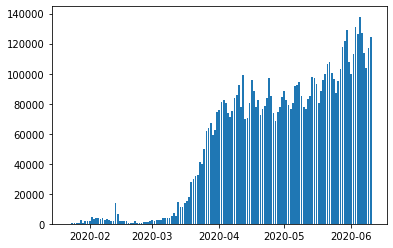

In [51]:
plt.bar(day_wise['Date'], day_wise['New cases'])